In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_df = pd.read_csv('train_df.csv')
X_train = train_df.drop(columns=['Mood Label'])
y_train = train_df['Mood Label']

In [3]:
class_weights = dict(train_df['Mood Label'].value_counts(normalize=True))

In [4]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}

In [5]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight=class_weights),
                           param_grid, cv=5, scoring='accuracy')

In [6]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={'ambient': 0.054466230936819175,
                                                            'enigmatic': 0.08932461873638345,
                                                            'epic': 0.10893246187363835,
                                                            'focus': 0.10893246187363835,
                                                            'happy': 0.10893246187363835,
                                                            'relax': 0.10893246187363835,
                                                            'romance': 0.10893246187363835,
                                                            'sad': 0.10893246187363835,
                                                            'tranquil': 0.09368191721132897,
                                                            'upbeat': 0.10893246187363835},
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [7]:
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'max_depth': 20, 'n_estimators': 50}


In [8]:
best_random_forest_classifier = grid_search.best_estimator_

In [9]:
best_random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight={'ambient': 0.054466230936819175,
                                     'enigmatic': 0.08932461873638345,
                                     'epic': 0.10893246187363835,
                                     'focus': 0.10893246187363835,
                                     'happy': 0.10893246187363835,
                                     'relax': 0.10893246187363835,
                                     'romance': 0.10893246187363835,
                                     'sad': 0.10893246187363835,
                                     'tranquil': 0.09368191721132897,
                                     'upbeat': 0.10893246187363835},
                       max_depth=20, n_estimators=50, random_state=42)

In [10]:
mod_spotify_df = pd.read_csv('mod_spotify_songs.csv')
spotify_df = pd.read_csv('final_spotify_songs.csv')

In [11]:
predicted_moods_rf = best_random_forest_classifier.predict(mod_spotify_df)

In [12]:
mod_spotify_df['predicted_mood_hprf'] = predicted_moods_rf

In [13]:
spotify_df['predicted_mood'] = mod_spotify_df['predicted_mood_hprf']

In [14]:
mod_spotify_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,predicted_mood_hprf
0,0.565,0.962,8,-2.981,1,0.0640,0.437,0.000000,0.0560,0.906,148.808,160227,happy
1,0.474,0.598,5,-5.023,1,0.0973,0.768,0.000000,0.0841,0.917,184.484,131853,romance
2,0.647,0.582,10,-9.538,0,0.0755,0.410,0.000002,0.0715,0.915,167.396,146480,epic
3,0.688,0.700,7,-6.295,1,0.0757,0.730,0.000000,0.7270,0.876,119.117,142547,epic
4,0.168,0.326,5,-9.981,1,0.0324,0.721,0.000600,0.3160,0.322,174.794,182400,sad


In [15]:
accuracy = accuracy_score(y_train, best_random_forest_classifier.predict(X_train))
precision = precision_score(y_train, best_random_forest_classifier.predict(X_train), average='weighted')
recall = recall_score(y_train, best_random_forest_classifier.predict(X_train), average='weighted')
f1 = f1_score(y_train, best_random_forest_classifier.predict(X_train), average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9814814814814815
Precision: 0.9815781966070204
Recall: 0.9814814814814815
F1 Score: 0.9814615768344661


In [16]:
conf_matrix = confusion_matrix(y_train, best_random_forest_classifier.predict(X_train))
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 50   0   0   0   0   0   0   0   0   0]
 [  0  82   0   0   0   0   0   0   0   0]
 [  0   0  97   0   3   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  0   0   3   0  97   0   0   0   0   0]
 [  0   0   0   0   0 100   0   0   0   0]
 [  0   0   0   0   0   0  96   3   0   1]
 [  0   0   0   0   0   0   7  93   0   0]
 [  0   0   0   0   0   0   0   0  86   0]
 [  0   0   0   0   0   0   0   0   0 100]]


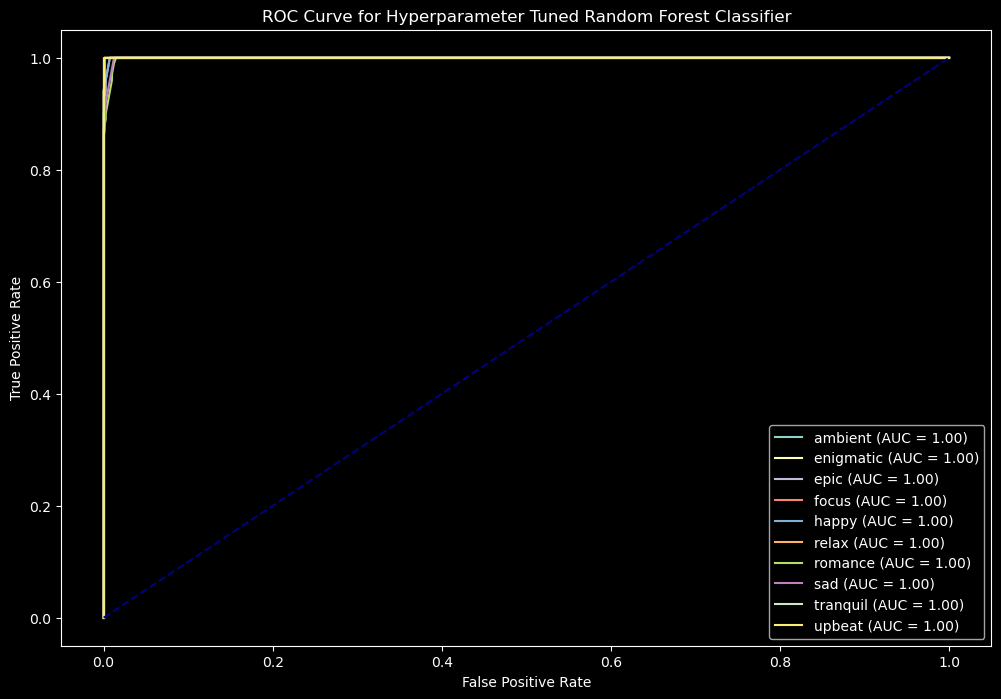

In [17]:
classes = np.unique(y_train)
plt.figure(figsize=(12, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_train == classes[i], best_random_forest_classifier.predict_proba(X_train)[:, i])
    roc_auc = roc_auc_score(y_train == classes[i], best_random_forest_classifier.predict_proba(X_train)[:, i])
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hyperparameter Tuned Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [18]:
spotify_df.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_genre,playlist_subgenre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,predicted_mood
0,7DJsL4jyXA39GDiHFQYQ0t,Mess Around,Ray Charles,"Ah, you can talk about the pit barbecue The ba...",59,0cw6Sv7IwZ87aLPPvNPSd0,"Ray Charles (aka: Hallelujah, I Love Her So)",1957-01-01,r&b,urban contemporary,...,-2.981,1,0.0640,0.437,0.000000,0.0560,0.906,148.808,160227,happy
1,6qb0O5HW7H4q6R0AbP38Ko,Long Tall Sally (The Thing),Little Richard,Going to tell Aunt Mary about Uncle John He cl...,1,4CfyfJWb1HSabAjdcLeThs,Here's Little Richard [Remastered & Expanded],1957-03-01,rock,classic rock,...,-5.023,1,0.0973,0.768,0.000000,0.0841,0.917,184.484,131853,romance
2,4gphxUgq0JSFv2BCLhNDiE,Jailhouse Rock,Elvis Presley,The warden threw a party in the county jail Th...,73,0C3t1htEDTFKcg7F2rNbek,Elvis' Golden Records,1958-03-21,rock,classic rock,...,-9.538,0,0.0755,0.410,0.000002,0.0715,0.915,167.396,146480,epic
3,7jER4hFurkqwYmeat3qsh5,Jingle Bells,Ella Fitzgerald,Dashing through the snow In a one-horse open s...,11,15up0e6AFIYZbmErIVPU3p,Ella Wishes You A Swinging Christmas (Expanded...,1960-01-01,r&b,neo soul,...,-6.295,1,0.0757,0.730,0.000000,0.7270,0.876,119.117,142547,epic
4,0CmIALzGn4vHIHJG4n3Q4z,At Last - Single Version,Etta James,I was never spellbound by a starry sky What is...,25,2pBhXw3Hi1hBf8FpAtE101,At Last!,1960-01-01,r&b,urban contemporary,...,-9.981,1,0.0324,0.721,0.000600,0.3160,0.322,174.794,182400,sad


In [20]:
spotify_df.to_csv('spotify-data-hyper-rfc-final.csv', index=False)